In [303]:
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [264]:
data = json.load(open('to-grade/all-singles.json'))
dataset = json.load(open('conala-dataset.json'))

In [265]:
def get_key(k):
    if k.endswith('-rerank'):
        return k.replace('-rerank', '-bleu-rerank')
    return k + '-bleu'

def get_val(d2, k):
    k = k.replace('grade-', '')
    if k == 'snippet':
        return 1.
    return d2[get_key(k.replace('grade-', ''))]

In [266]:
pairs = []
for d1, d2 in zip(data, dataset):
    assert d1['snippet'] == d2['snippet']
    or_intent = d2['rewritten_intent'] if d2['rewritten_intent'] is not None else d2['intent']
    assert d1['intent'] == or_intent
    for k in d1:
        if k.startswith('grade-'):
            pairs.append((
                d1[k], 
                get_val(d2, k)
            ))

In [267]:
pairs[:5], len(pairs)

([(4, 1.0), (0, 0.1251), (0, 0.115), (1, 0.3554), (4, 1.0)], 1000)

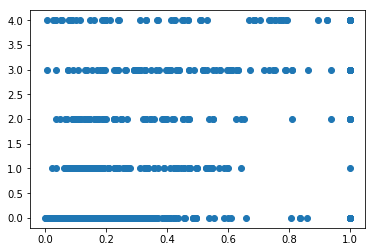

In [269]:
plt.plot([p[1] for p in pairs], [p[0] for p in pairs], 'o')

In [270]:
from scipy.stats import pearsonr
import numpy as np

In [271]:
scores = np.array([p[0] for p in pairs])
bleu = np.array([p[1] for p in pairs])

In [272]:
pearsonr(scores, bleu)

(0.7525275989044806, 3.048168615331587e-183)

In [273]:
# inds = np.logical_or(0 == scores, scores == 4)
inds = np.logical_and(0 <= scores, scores < 4)
pearsonr(scores[inds], bleu[inds])

(0.5243018982444255, 3.0408025206609425e-55)

In [274]:
np.unique(scores, return_counts=True)

(array([0, 1, 2, 3, 4]), array([483, 109,  70, 103, 235]))

In [287]:
buckets = np.zeros((5, 5), dtype=np.int32)

for pair in pairs:
    score, bleu = pair
    ind = min(4, int(bleu / 0.2))
    buckets[ind, score] += 1

In [301]:
buckets[0, 0] = buckets[-1, -1] = 0
buckets.ravel()

array([  0,  50,  29,  16,  21, 101,  28,  21,  21,   8,  21,  29,  10,
        21,  11,   2,   1,   3,  14,  16,  13,   1,   7,  31,   0],
      dtype=int32)

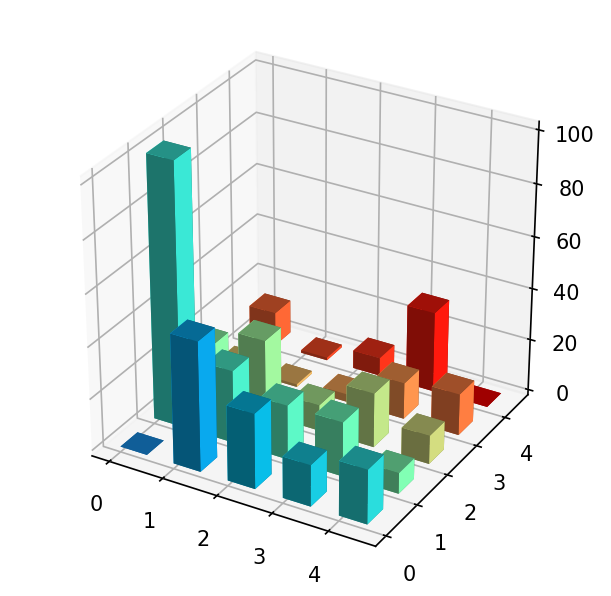

In [302]:

fig=plt.figure(figsize=(5, 5), dpi=150)
ax1=fig.add_subplot(111, projection='3d')

xpos = np.arange(5)
ypos = np.arange(5)

xposM, yposM = np.meshgrid(xpos, ypos, copy=False)

zpos = buckets.ravel()

dx=0.5
dy=0.5
dz=zpos

# ax1.w_xaxis.set_ticks(xpos + dx/2.)

# ax1.w_yaxis.set_ticks(ypos + dy/2.)

values = np.linspace(0.2, 1., xposM.ravel().shape[0])
colors = cm.rainbow(values)
ax1.bar3d(xposM.ravel(), yposM.ravel(), dz*0, dx, dy, dz, color=colors)
plt.show()